> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: June 17th, 2025. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">[Group 10: 최광일, 정성호]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-06-04 07:33:07.062247


The objective of this assignment is to address the domain generalization problem in neural networks.

In [2]:
# You may change the values below.
team_id = '010' # your team id - should be a three-digit number
root_dir = '../../PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 7 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model.pth' # model name
TEST_MODE = False # test mode -- evaluation for TAs

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
class PACSDataset(Dataset):
	def __init__(self, root_dir, domain, transform=None):
		"""
		Args:
			root_dir (string): Directory with all the images.
			domains (list): Containing domains of interest, with element choices: 
				['photo', 'art_painting', 'cartoon', 'sketch'].
			transform (callable, optional): Optional transform to be applied on a sample.
		"""        
		self.root_dir = root_dir
		self.domain = domain
		self.transform = transform

		self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
		self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

		self.images = []
		self.labels = []

		# Load images and labels
		domain_dir = os.path.join(self.root_dir, self.domain)
		for cls_name in self.classes:
			cls_dir = os.path.join(domain_dir, cls_name)
			image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png'))]

			for img_name in image_files:
				self.images.append(os.path.join(cls_dir, img_name))
				self.labels.append(self.class_to_idx[cls_name])

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = self.images[idx]
		image = Image.open(img_path).convert('RGB')
		label = self.labels[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

In [5]:
# Define transforms
transform_train = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_train),
	PACSDataset(root_dir, 'art_painting', transform=transform_train),
	PACSDataset(root_dir, 'sketch', transform=transform_train),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [6]:
# Let's visualize some images from the training set

import matplotlib.pyplot as plt
import numpy as np

def visualize_example_images(root_dir, domain):
	assert domain in ['art_painting', 'sketch', 'cartoon']

	def denormalize(tensor):
		"""Denormalize the image tensor for visualization"""
		mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
		std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
		return tensor * std + mean
	
 	# Create dataset
	dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_train)

	# Create a figure with subplots for each class
	fig, axs = plt.subplots(1, 7, figsize=(15, 3))
	fig.suptitle('Sample Images from Each Category')

	# For each class
	for i, class_name in enumerate(dataset.classes):
		# Find first image of this class
		for idx in range(len(dataset)):
			if dataset.labels[idx] == i:
				image, _ = dataset[idx]
				
				# Denormalize the image
				image = denormalize(image)
				
				# Convert to numpy and transpose for plotting
				image = image.numpy().transpose(1, 2, 0)
				
				# Clip values to [0, 1] range
				image = np.clip(image, 0, 1)
				
				# Plot
				axs[i].imshow(image)
				axs[i].set_title(class_name)
				axs[i].axis('off')
				break

	plt.tight_layout()
	plt.show()

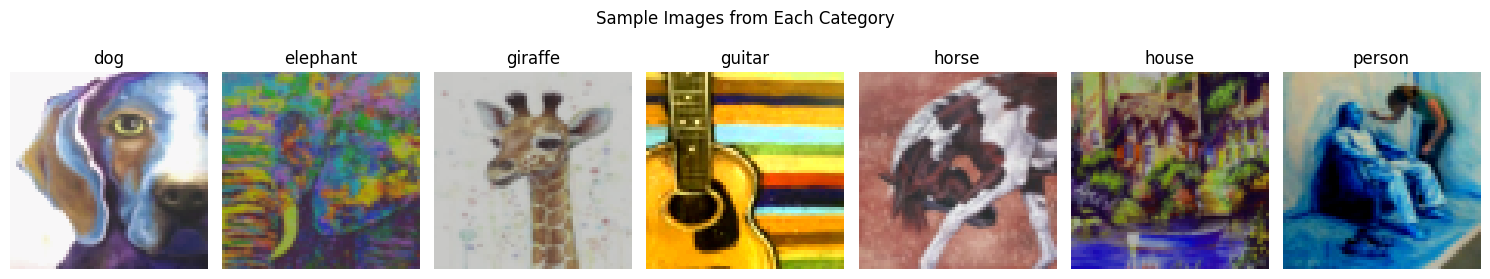

In [7]:
visualize_example_images(root_dir, 'art_painting')

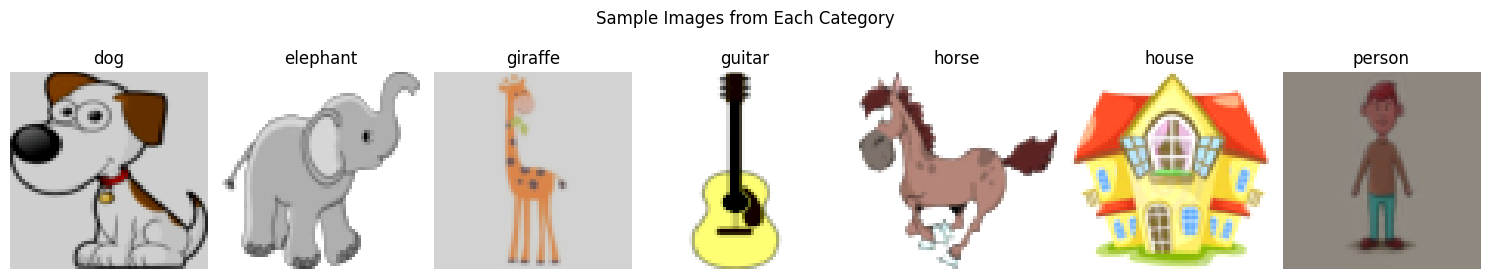

In [8]:
visualize_example_images(root_dir, 'cartoon')

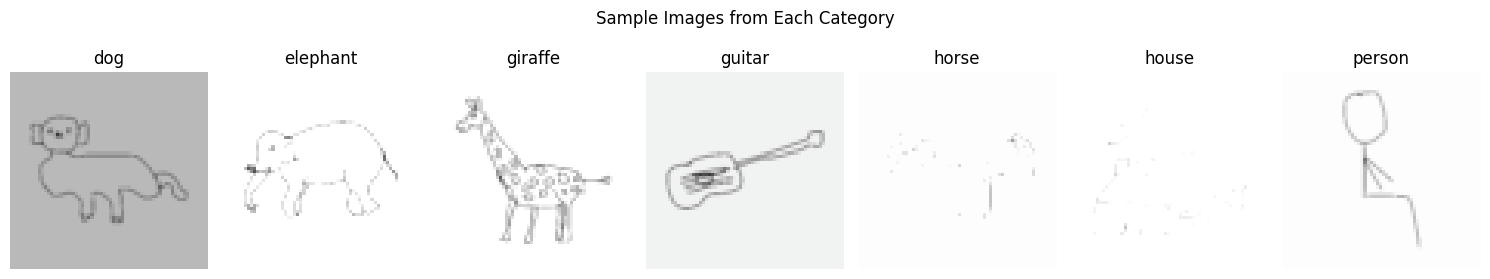

In [9]:
visualize_example_images(root_dir, 'sketch')

In [10]:
# Load ResNet50 model pre-trained on ImageNet
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)

In [11]:
# Instantiate loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

Epoch 1/10: 100%|██████████| 261/261 [00:38<00:00,  6.87it/s]


Epoch [1/10], Loss: 1.8487, Test Accuracy: 41.14%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:37<00:00,  6.98it/s]


Epoch [2/10], Loss: 1.5853, Test Accuracy: 58.26%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [3/10], Loss: 1.3550, Test Accuracy: 64.61%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:37<00:00,  6.98it/s]


Epoch [4/10], Loss: 1.1942, Test Accuracy: 61.62%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:37<00:00,  6.98it/s]


Epoch [5/10], Loss: 1.0832, Test Accuracy: 66.17%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:37<00:00,  6.96it/s]


Epoch [6/10], Loss: 0.9903, Test Accuracy: 68.50%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:37<00:00,  6.96it/s]


Epoch [7/10], Loss: 0.9205, Test Accuracy: 69.64%, Learning Rate: 0.000010


Epoch 8/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [8/10], Loss: 0.8784, Test Accuracy: 69.70%, Learning Rate: 0.000010


Epoch 9/10: 100%|██████████| 261/261 [00:37<00:00,  6.89it/s]


Epoch [9/10], Loss: 0.8742, Test Accuracy: 71.38%, Learning Rate: 0.000010


Epoch 10/10: 100%|██████████| 261/261 [00:37<00:00,  6.95it/s]


Epoch [10/10], Loss: 0.8692, Test Accuracy: 68.44%, Learning Rate: 0.000010
Finished Training


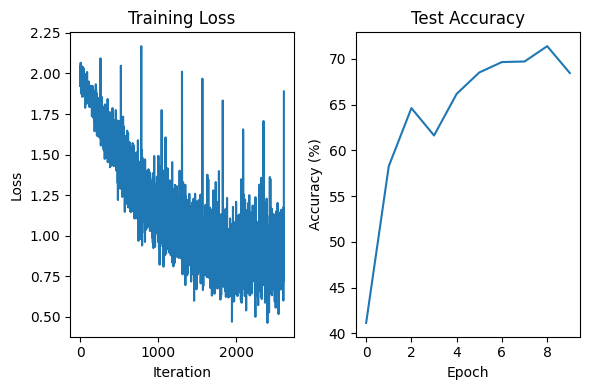

In [12]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model = model.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels = inputs.to(device), labels.to(device)

			optimizer.zero_grad()

			outputs = model(inputs)

			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler.step()

		# Validation
		model.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model.state_dict(), f'./{model_name}_base')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

# Base Model Test

In [13]:
# Load model
del model
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # ✅ pretrained=True와 동일
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 7)  # ✅ PACS용 7개 클래스 출력
state_dict = torch.load(f'./{model_name}_base')   # ✅ weights_only 제거
model.load_state_dict(state_dict)
model.eval()
model.to(device)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        for cls_name in self.class_to_idx.keys():
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test data
root_dir_test = './CuratedPACS'
dataset_test = CustomDataset(root_dir_test, transform=transform_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # 라벨 문자열 출력
        for t, p in zip(labels.cpu(), predicted.cpu()):
            true_name = dataset_test.idx_to_class[t.item()]
            pred_name = dataset_test.idx_to_class[p.item()]
            print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

/tmp/ipykernel_4027149/3604639118.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./{model_name}_base')   # ✅ weights_only 제거


GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: house    ❌
GT: elephant | Pred: horse    ❌
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: guitar   | Pred: person   ❌
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: person   ❌
GT: guitar   | Pred: guitar   ✅
GT: horse    | Pred: person   ❌
GT: horse    | Pred: house    ❌
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: person   ❌
GT: horse    | Pred: horse    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: person   | Pred: person   ✅
GT: pers

# New model Train

In [14]:
class PACSDatasetWithDomain(PACSDataset):
    def __init__(self, root_dir, domain_name, domain_id, transform=None):
        super().__init__(root_dir, domain_name, transform=transform)
        self.domain_id = domain_id

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, label, self.domain_id

# 도메인별 정수 ID 지정
domain_to_id = {'cartoon': 0, 'art_painting': 1, 'sketch': 2}

dataset_train_new = ConcatDataset([
    PACSDatasetWithDomain(root_dir, 'cartoon', domain_to_id['cartoon'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'art_painting', domain_to_id['art_painting'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'sketch', domain_to_id['sketch'], transform=transform_train),
])
dataset_test_new = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train_new = DataLoader(dataset_train_new, batch_size=batch_size, shuffle=True)
loader_test_new = DataLoader(dataset_test_new, batch_size=batch_size, shuffle=False)

In [15]:
# 수정된 ResNet50 with intermediate feature hook
class ResNetWithFeatures(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # fc 제거
        self.fc = nn.Linear(base.fc.in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # flatten
        logits = self.fc(features)
        if return_features:
            return logits, features
        return logits

model_new = ResNetWithFeatures(num_classes=7)

In [16]:
# Instantiate loss, optimizer, and scheduler
criterion_new = nn.CrossEntropyLoss()
optimizer_new = optim.SGD(model_new.parameters(), lr=lr, momentum=0.9)
scheduler_new = lr_scheduler.StepLR(optimizer_new, step_size=step_size, gamma=0.1)

In [17]:
# MMD 구현 함수
def compute_mmd(x1, x2, kernel='rbf', sigma=None):
    """Compute Maximum Mean Discrepancy (MMD) between two sets of features."""
    def gaussian_kernel(x, y, sigma):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = ((x - y) ** 2).sum(2)
        if sigma is None:
            sigma = torch.sqrt(torch.mean(dist)).detach()  # 동적 추정
        return torch.exp(-dist / (2 * sigma ** 2 + 1e-8))

    Kxx = gaussian_kernel(x1, x1, sigma)
    Kyy = gaussian_kernel(x2, x2, sigma)
    Kxy = gaussian_kernel(x1, x2, sigma)
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

In [ ]:
if not TEST_MODE:
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

	model_new = model_new.to(device)

	# Lists to store loss and accuracy values
	train_losses = []
	test_accuracies = []

	for epoch in range(num_epochs):
		model_new.train()
		running_loss = 0.0
		correct = 0
		total = 0

		cls_tot = 0.0
		cls_cnt = 0
		mmd_tot = 0.0
		mmd_cnt = 0

		lambda_mmd = 0.1  # MMD 손실 가중치

		for i, (inputs, labels, domains) in enumerate(tqdm(loader_train_new, desc=f'Epoch {epoch+1}/{num_epochs}')):
			inputs, labels, domains = inputs.to(device), labels.to(device), domains.to(device)

			optimizer_new.zero_grad()

			outputs, features = model_new(inputs, return_features=True)

			loss = criterion_new(outputs, labels)

			cls_tot += loss.item()
			cls_cnt += 1

			unique_domains = torch.unique(domains)
			mmd_loss = 0.0
			for i in range(len(unique_domains)):
				for j in range(i + 1, len(unique_domains)):
					f1 = features[domains == unique_domains[i]]
					f2 = features[domains == unique_domains[j]]
					if len(f1) > 1 and len(f2) > 1:  # 최소 두 개 이상 있어야 MMD 계산 가능
						mmd_loss += compute_mmd(f1, f2)
						mmd_tot += mmd_loss.item()
						mmd_cnt += 1

			loss = loss #+ lambda_mmd * mmd_loss
			loss.backward()
			optimizer_new.step()

			running_loss += loss.item()
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			# Store loss at every iteration
			train_losses.append(loss.item())
			
		scheduler_new.step()

		# Validation
		model_new.eval()
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in loader_test_new:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs, features = model_new(inputs, return_features=True)
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

		test_accuracy = 100 * correct / total
		test_accuracies.append(test_accuracy)
	
		current_lr = optimizer_new.param_groups[0]['lr']
		print(f'Epoch [{epoch+1}/{num_epochs}], '
					f'Loss: {running_loss/len(loader_train_new):.4f}, '
					f'Test Accuracy: {test_accuracy:.2f}%, '
					f'Learning Rate: {current_lr:.6f}, '
					f'Average MMD: {mmd_tot / (mmd_cnt + 1e-5):.4f}, '
					f'Average CLS: {cls_tot / (cls_cnt + 1e-5):.4f}')

	print('Finished Training')

	# Save the model - make sure you include this file in your submission
	torch.save(model_new.state_dict(), f'./{model_name}')

	# Plotting after training is finished
	plt.figure(figsize=(6, 4))

	# Plot training loss
	plt.subplot(1, 2, 1)
	plt.plot(train_losses)
	plt.title('Training Loss')
	plt.xlabel('Iteration')
	plt.ylabel('Loss')

	# Plot test accuracy
	plt.subplot(1, 2, 2)
	plt.plot(test_accuracies)
	plt.title('Test Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')

	plt.tight_layout()
	plt.show()

Epoch 1/10: 100%|██████████| 261/261 [00:39<00:00,  6.68it/s]


Epoch [1/10], Loss: 1.8295, Test Accuracy: 27.66%, Learning Rate: 0.000100, Average MMD: 0.0459, Average CLS: 1.8295


Epoch 2/10: 100%|██████████| 261/261 [00:39<00:00,  6.67it/s]


Epoch [2/10], Loss: 1.5341, Test Accuracy: 48.14%, Learning Rate: 0.000100, Average MMD: 0.0454, Average CLS: 1.5341


Epoch 3/10: 100%|██████████| 261/261 [00:39<00:00,  6.66it/s]


Epoch [3/10], Loss: 1.3106, Test Accuracy: 59.28%, Learning Rate: 0.000100, Average MMD: 0.0456, Average CLS: 1.3106


Epoch 4/10: 100%|██████████| 261/261 [00:39<00:00,  6.65it/s]


Epoch [4/10], Loss: 1.1682, Test Accuracy: 62.22%, Learning Rate: 0.000100, Average MMD: 0.0457, Average CLS: 1.1682


Epoch 5/10: 100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


Epoch [5/10], Loss: 1.0462, Test Accuracy: 63.77%, Learning Rate: 0.000100, Average MMD: 0.0471, Average CLS: 1.0462


Epoch 6/10: 100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


Epoch [6/10], Loss: 0.9607, Test Accuracy: 66.59%, Learning Rate: 0.000100, Average MMD: 0.0482, Average CLS: 0.9607


Epoch 7/10: 100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


Epoch [7/10], Loss: 0.9056, Test Accuracy: 67.19%, Learning Rate: 0.000010, Average MMD: 0.0477, Average CLS: 0.9056


Epoch 8/10:  23%|██▎       | 59/261 [00:09<00:30,  6.57it/s]

# New model Test

In [ ]:
# Load model
del model_new
model_new = ResNetWithFeatures(num_classes=7)
model_new.load_state_dict(torch.load(f'./{model_name}'))
model_new.eval()
model_new.to(device)

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        for cls_name in self.class_to_idx.keys():
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test data
root_dir_test = './CuratedPACS'
dataset_test_new = CustomDataset(root_dir_test, transform=transform_test)
loader_test_new = DataLoader(dataset_test_new, batch_size=batch_size, shuffle=False)

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in loader_test_new:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_new(inputs)
        _, predicted = outputs.max(1)

        # 라벨 문자열 출력
        for t, p in zip(labels.cpu(), predicted.cpu()):
            true_name = dataset_test_new.idx_to_class[t.item()]
            pred_name = dataset_test_new.idx_to_class[p.item()]
            print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

/tmp/ipykernel_3971220/145216994.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load(f'./{model_name}'))


GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: dog      ❌
GT: elephant | Pred: horse    ❌
GT: elephant | Pred: house    ❌
GT: elephant | Pred: horse    ❌
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: giraffe  ✅
GT: giraffe  | Pred: horse    ❌
GT: guitar   | Pred: giraffe  ❌
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: guitar   ✅
GT: guitar   | Pred: dog      ❌
GT: guitar   | Pred: person   ❌
GT: horse    | Pred: house    ❌
GT: horse    | Pred: person   ❌
GT: horse    | Pred: horse    ✅
GT: horse    | Pred: person   ❌
GT: horse    | Pred: horse    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: house    | Pred: house    ✅
GT: person   | Pred: person   ✅
GT: pers

In [ ]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')